# Exploring data and features

## Core Features that could be added:

### Price-Based Features:

- Returns: 1-day, 3-day, 5-day, 10-day returns
- Price ratios: Current price / MA(5), Current price / MA(20)
- Gap features: (Open - Previous Close) / Previous Close
- Intraday range: (High - Low) / Close

### Volume Features:

- Volume ratios: Current volume / MA(20 volume)
- Price-volume: Return * Volume (captures momentum with conviction)

### Technical Indicators:

- RSI (14-day) - momentum oscillator
- MACD signal (12,26,9) - trend following
- Bollinger Band position: (Price - BB_lower) / (BB_upper - BB_lower)

### Market Context:

- VIX level (fear index)
- Sector/market performance: Stock return vs S&P 500 return
- Day of week dummy variables

### Target Variable:

- Binary: 1 if next day's close > today's close, 0 otherwise

# Load csv data

In [80]:
import pandas as pd

data = pd.read_csv("../.data/interim/data_with_target.csv", index_col=0)


In [15]:
data

,Date,Ticker,Close,High,Low,Open,Volume,WTI_Oil,US10Y,VIX,DJI,GSPC,NDX,RUT,Target
0,2020-01-02,AAPL,72.538521,72.598899,71.292311,71.545897,135480400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,1
2,2020-01-02,BA,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,2
3,2020-01-02,BAC,30.920326,30.937678,30.616677,30.668729,37614200,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
4,2020-01-02,BHP,33.608604,33.822789,33.522933,33.792192,1382193,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25155,2024-12-31,QQQ,509.896118,516.309303,508.928648,515.551337,29117000,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
25156,2024-12-31,SPY,582.599915,587.132835,580.949738,586.407129,57052700,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
25157,2024-12-31,T,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
25158,2024-12-31,VTI,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1


# Add features
Doing this before one-hot encoding stocks will make it easier for calculations

In [81]:
import talib

# ===== Macro features =====
#data['VIX_ret'] = data['VIX'].pct_change() # very noisy fro day-to-day
#data['WTI_ret'] = data['WTI_Oil'].pct_change()
#data['TNX_ret'] = data['US10Y'].pct_change()
data['VIX_5d_mean'] = data['VIX'].rolling(5).mean()
data['WTI_5d_std'] = data['WTI_Oil'].rolling(5).std()

# ===== Market indices =====
market_indices = ["GSPC", "NDX", "RUT", "DJI"]
for idx in market_indices:
    data[f'{idx}_return_1d'] = data[idx].pct_change()
    data[f'{idx}_return_5d'] = data[idx].pct_change(5)

# ===== Stock returns =====
for period in [1, 3, 5, 10]:
    data[f'return_{period}d'] = data.groupby('Ticker')['Close'].pct_change(period)

# ===== Rolling volatility =====
data['rolling_std_5'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(5).std())
data['rolling_std_10'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(10).std())


# ===== Moving averages and ratios =====
data['ma_5'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(5).mean())
data['ma_20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
data['price_ma5_ratio'] = data['Close'] / data['ma_5']
data['price_ma20_ratio'] = data['Close'] / data['ma_20']
data['MA5_MA20_diff'] = data['ma_5'] - data['ma_20']
data['MA5_MA20_ratio'] = data['ma_5'] / data['ma_20']

# ===== Volume features =====
data['vol_MA5'] = data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(5).mean())
data['vol_MA20'] = data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
data['vol_ratio_5'] = data['Volume'] / data['vol_MA5']
data['vol_ratio_20'] = data['Volume'] / data['vol_MA20']
# data['price_volume'] = data['return_1d'] * data['Volume']

# ===== Momentum indicators =====
data['rsi'] = data.groupby('Ticker')['Close'].transform(lambda x: talib.RSI(x.values, timeperiod=14))
data['macd'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean() - x.ewm(span=26, adjust=False).mean())
data['macd_signal'] = data.groupby('Ticker')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
data['macd_hist'] = data['macd'] - data['macd_signal']
data.drop(columns=['macd_signal'], inplace=True)

# ===== True Range & ATR =====
data['tr'] = data['High'] - data['Low']
data['tr1'] = abs(data['High'] - data['Close'].shift(1))
data['tr2'] = abs(data['Low'] - data['Close'].shift(1))
data['true_range'] = data[['tr', 'tr1', 'tr2']].max(axis=1)
data['ATR_14'] = data.groupby('Ticker')['true_range'].transform(lambda x: x.rolling(14).mean())
data['ATR_7'] = data.groupby('Ticker')['true_range'].transform(lambda x: x.rolling(7).mean())
data.drop(columns=['tr','tr1','tr2','true_range'], inplace=True)

# ===== Bollinger Bands =====
ma20 = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
std20 = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).std())
data['BB_width'] = (2 * std20) / ma20

# ===== Price Range Features =====
data['range_pct'] = (data['High'] - data['Low']) / data['Close']
data['OC_pct'] = (data['Close'] - data['Open']) / data['Close']
data['range_5d'] = data.groupby('Ticker').apply(lambda x: (x['High'].rolling(5).max() - x['Low'].rolling(5).min()) / x['Close']).reset_index(level=0, drop=True)

C:\Users\maria\AppData\Local\Temp\ipykernel_30556\732600463.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['range_5d'] = data.groupby('Ticker').apply(lambda x: (x['High'].rolling(5).max() - x['Low'].rolling(5).min()) / x['Close']).reset_index(level=0, drop=True)


## Handle NaNs

XGBoost can handle NaNs in features, except in the target variable. For now I will fill them anyway.

In [82]:
data.bfill(inplace=True)
data.ffill(inplace=True)

In [18]:
data

,Date,Ticker,Close,High,Low,Open,Volume,WTI_Oil,US10Y,VIX,...,price_volume,rsi,macd,macd_hist,ATR_14,ATR_7,BB_width,range_pct,OC_pct,range_5d
0,2020-01-02,AAPL,72.538521,72.598899,71.292311,71.545897,135480400,61.180000,1.882,12.47,...,-1.422588e+06,71.902472,0.000000,0.000000,20.728148,17.330325,0.053619,0.018012,0.013684,0.038557
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,...,-1.422588e+06,71.902472,0.000000,0.000000,20.728148,17.330325,0.053619,0.017840,0.012123,0.038557
2,2020-01-02,BA,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,...,-1.422588e+06,71.902472,0.000000,0.000000,20.728148,17.330325,0.053619,0.016951,0.014311,0.038557
3,2020-01-02,BAC,30.920326,30.937678,30.616677,30.668729,37614200,61.180000,1.882,12.47,...,-1.422588e+06,71.902472,0.000000,0.000000,20.728148,17.330325,0.053619,0.010382,0.008137,0.038557
4,2020-01-02,BHP,33.608604,33.822789,33.522933,33.792192,1382193,61.180000,1.882,12.47,...,-1.422588e+06,71.902472,0.000000,0.000000,20.728148,17.330325,0.053619,0.008922,-0.005463,0.038557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25155,2024-12-31,QQQ,509.896118,516.309303,508.928648,515.551337,29117000,71.720001,4.573,17.35,...,-2.473405e+05,44.908909,2.612441,-2.121156,501.992761,497.993835,0.027283,0.014475,-0.011091,0.041038
25156,2024-12-31,SPY,582.599915,587.132835,580.949738,586.407129,57052700,71.720001,4.573,17.35,...,-2.075598e+05,41.593597,-0.428326,-1.758566,73.565519,72.872417,0.025052,0.010613,-0.006535,0.030832
25157,2024-12-31,T,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,...,1.581095e+05,47.674544,-0.020294,-0.075379,570.391221,568.522518,0.039074,0.010979,0.006588,0.031181
25158,2024-12-31,VTI,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,...,-1.352065e+04,40.698750,-0.552695,-1.010487,272.964054,270.932713,0.028975,0.010593,-0.006901,0.031055


## One-hot encode ticker values

In [83]:

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_values = encoder.fit_transform(data[['Ticker']])
new_cols = encoder.get_feature_names_out(['Ticker'])

tickers_encoded = pd.DataFrame(encoded_values, columns=new_cols, index=data.index)

data = pd.concat(
    [data, tickers_encoded],
    axis=1
)

## Walk-foward validation

In [247]:
from sklearn.model_selection import train_test_split


returns = ['return_1d', 'return_3d', 'return_5d']
rolling_volatility = ['rolling_std_5', 'rolling_std_10']
moving_avg = ['ma_5', 'ma_20', 'price_ma5_ratio', 'price_ma20_ratio', 'MA5_MA20_diff'] # 'MA5_MA20_ratio'] 
momentum_indicators = [] # ['rsi', 'macd', 'macd_hist']
volume_features = [] #  ['price_volume'] # 'vol_MA5', 'vol_MA20', 'vol_ratio_5', 'vol_ratio_20', 
macro_features = [] # ['VIX_5d_mean', 'WTI_5d_std'] # 'VIX_ret', 'WTI_ret', 'TNX_ret',
market_index_features = [] # ["GSPC_return_1d", "NDX_return_1d", "RUT_return_1d", "DJI_return_1d", "GSPC_return_5d", "NDX_return_5d", "RUT_return_5d", "DJI_return_5d"] # (make almost no diff)
atr = ['ATR_14', 'ATR_7']
bb = ['BB_width']
price_range = [] # ['range_pct', 'OC_pct', 'range_5d']

feature_columns = returns\
    + rolling_volatility\
    + moving_avg\
    + momentum_indicators\
    + volume_features\
    + macro_features\
    + market_index_features\
    + atr\
    + bb\
    + price_range
    #\
    #+ new_cols.tolist()


data[feature_columns] = data.groupby('Ticker')[feature_columns].shift(1) # prevent data leakage from using same-day data

X = data[feature_columns + ['Date', 'Close', 'Ticker']]
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# ===== Data for trading simulation =====
X_test_sim = X_test[['Date', 'Close', 'Ticker']].copy()

X_train = X_train[feature_columns]
X_test = X_test[feature_columns]

## Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.5, 1.0]
}

# Need TimeSeriesSplit for financial data
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=tscv,
    verbose=1, 
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


## Feature selection based on performance

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score

base_features = feature_columns
candidate_feature_sets =  [[], ['VIX_5d_mean', 'WTI_5d_std']]

for ft in candidate_feature_sets:
    model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,

        # Obtained from hyperparameter tuning
        subsample=0.9,
        reg_lambda=1.0,
        reg_alpha=0,
        n_estimators=100,
        min_child_weight=5,
        max_depth=4,
        learning_rate=0.05,
        colsample_bytree=0.8
    )

    X1 = data[base_features + ft]
    y1 = data['Target']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)

    weights = y1_train.map(class_weights)

    model.fit(X1_train, y1_train, sample_weight=weights)

    y1_pred = model.predict(X1_test)

    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X1, y1, cv=tscv,
                                scoring=make_scorer(balanced_accuracy_score))
    print('Added features: ' + str(ft))
    print('Balanced CV Accuracy:', scores.mean())

# Class imbalances

In [86]:
print("\nTraining set class distribution:")
train_counts = y_train.value_counts(normalize=True)
print(f"Class -1: {train_counts.get(0, 0):.1%}, "
      f"Class 0: {train_counts.get(1, 0):.1%}, "
      f"Class 1: {train_counts.get(2, 0):.1%}")

print("\nTest set class distribution:")
test_counts = y_test.value_counts(normalize=True)
print(f"Class -1: {test_counts.get(0, 0):.1%}, "
      f"Class 0: {test_counts.get(1, 0):.1%}, "
      f"Class 1: {test_counts.get(2, 0):.1%}")


Training set class distribution:
Class -1: 38.7%, Class 0: 16.1%, Class 1: 45.3%

Test set class distribution:
Class -1: 34.9%, Class 0: 19.8%, Class 1: 45.2%


## Account for class imbalances

In [219]:
import numpy as np
from sklearn.utils import compute_class_weight

classes = np.unique(y_train)
weights_array = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights_array))
# Map weights to training labels
sample_weight = y_train.map(class_weights)

# Train model

In [232]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,

    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3
)

model.fit(X_train, y_train, sample_weight=sample_weight)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


## Walk-foward validation

In [240]:
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score,
    balanced_accuracy_score,
    cohen_kappa_score
)

def evaluate_classification_model(y_test, y_pred):
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred, 
                               target_names=['down', 'flat', 'up']))
    
    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nRows=Actual, Cols=Predicted")
    
    # Overall metrics
    print("\n=== Overall Metrics ===")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"Macro F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
    print(f"Weighted F1: {f1_score(y_test, y_pred, average='weighted'):.3f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.3f}")
    
    # Per-class accuracy
    print("\n=== Per-Class Accuracy ===")
    for cls, name in enumerate(['down', 'flat', 'up']):
        mask = y_test == cls
        if mask.sum() > 0:
            cls_acc = (y_pred[mask] == cls).sum() / mask.sum()
            print(f"{name}: {cls_acc:.3f} ({mask.sum()} samples)")

In [248]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, gap=3)  # gap=3 for your 3-day prediction

X_array = data[feature_columns].values  # or X.to_numpy()
y_array = data['Target'].values

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X_array[train_idx], X_array[test_idx]
    y_train, y_test = y_array[train_idx], y_array[test_idx]


    classes = np.unique(y_train)
    weights_array = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights_array))
    # Map weights to training labels
    sample_weight = pd.Series(y_train).map(class_weights)
    
    # Train and evaluate
    model.fit(X_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(X_test)
    # Collect metrics

    evaluate_classification_model(y_test, y_pred)

=== Classification Report ===
              precision    recall  f1-score   support

        down       0.33      0.42      0.37      1353
        flat       0.22      0.25      0.23       812
          up       0.50      0.38      0.43      2028

    accuracy                           0.37      4193
   macro avg       0.35      0.35      0.34      4193
weighted avg       0.39      0.37      0.37      4193


=== Confusion Matrix ===
[[571 288 494]
 [337 201 274]
 [821 435 772]]

Rows=Actual, Cols=Predicted

=== Overall Metrics ===
Balanced Accuracy: 0.350
Macro F1: 0.345
Weighted F1: 0.374
Cohen's Kappa: 0.023

=== Per-Class Accuracy ===
down: 0.422 (1353 samples)
flat: 0.248 (812 samples)
up: 0.381 (2028 samples)
=== Classification Report ===
              precision    recall  f1-score   support

        down       0.43      0.40      0.41      1803
        flat       0.21      0.33      0.26       669
          up       0.42      0.35      0.38      1721

    accuracy                

## Make predictions

In [221]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test) # Probabilities for positive class

In [68]:
y_proba

array([[0.31472784, 0.42101797, 0.26425418],
       [0.49895287, 0.19058554, 0.31046155],
       [0.46521407, 0.28030053, 0.25448534],
       ...,
       [0.3013257 , 0.4493788 , 0.2492955 ],
       [0.34218675, 0.49076724, 0.16704595],
       [0.5291113 , 0.20055293, 0.27033573]],
      shape=(5032, 3), dtype=float32)

## Evaluate performance

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

### Evaluation metrics

In [222]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

print("\n📊 Classification Report:\n",
      classification_report(y_test, y_pred,
                            target_names=["Down", "Flat", "Up"]))

✅ Accuracy: 0.34578696343402227
✅ Balanced accuracy: 0.36657137860999245

📊 Classification Report:
               precision    recall  f1-score   support

        Down       0.37      0.37      0.37      1758
        Flat       0.23      0.45      0.30       998
          Up       0.48      0.28      0.36      2276

    accuracy                           0.35      5032
   macro avg       0.36      0.37      0.34      5032
weighted avg       0.39      0.35      0.35      5032



## Confusion Matrix

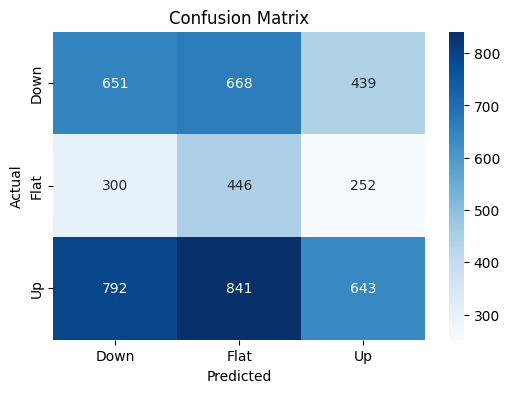

In [223]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down", "Flat", "Up"],
            yticklabels=["Down", "Flat", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ROC curves

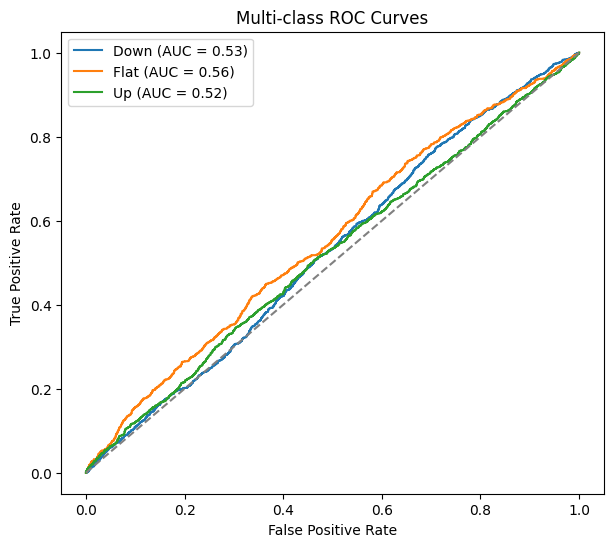

In [213]:
# Multi-class ROC Curves
y_test_bin = label_binarize(y_test, classes=[0,1,2])

plt.figure(figsize=(7,6))
for i, class_name in enumerate(["Down", "Flat", "Up"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend()
plt.show()

## Probability Distribution

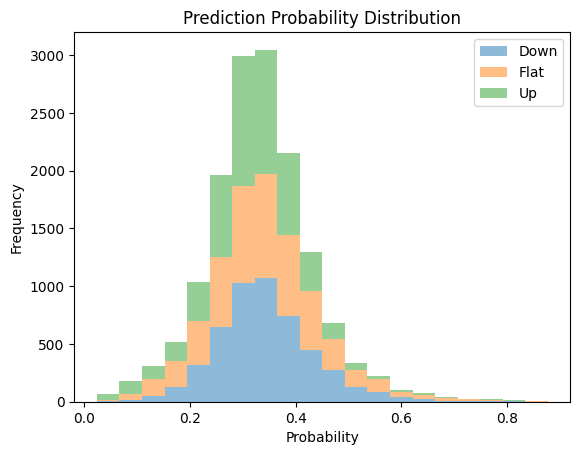

In [224]:
proba_df = pd.DataFrame(y_proba, columns=["Down", "Flat", "Up"])
proba_df.plot(kind="hist", bins=20, alpha=0.5, stacked=True)
plt.title("Prediction Probability Distribution")
plt.xlabel("Probability")
plt.show()

## Feature importance

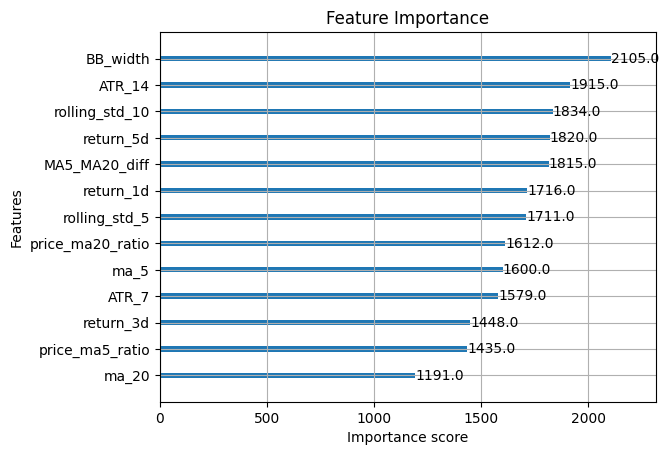

In [225]:
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

## Feature correlation

Return feature correlations:
           return_1d  return_3d  return_5d
return_1d   1.000000   0.585326   0.423443
return_3d   0.585326   1.000000   0.772034
return_5d   0.423443   0.772034   1.000000


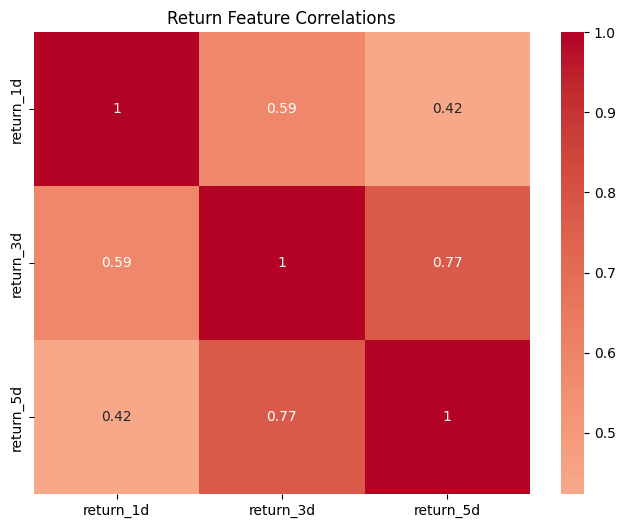

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation between your return features
return_features = ['return_1d', 'return_3d', 'return_5d']
correlation_matrix = X_train[return_features].corr()

print("Return feature correlations:")
print(correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Return Feature Correlations')
plt.show()

## Model validation

In [227]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Use TimeSeriesSplit for financial data (respects temporal order)
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation scores
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation scores: [0.42844365 0.43142516 0.42307692 0.46124031 0.43023256]
Mean CV accuracy: 0.4349 (+/- 0.0270)


Cross-validation scores: [0.44812165 0.42605844 0.42098986 0.46660704 0.39385808]
Mean CV accuracy: 0.4311 (+/- 0.0495)